# Introduction to Reward Models

## What is a Reward Model?

So you've got your model fine-tuned. It can follow instructions. It's polite. It's helpful. Great!

But here's the thing: it doesn't know which of its responses are *actually good*.

Think about it. After SFT (Supervised Fine-Tuning), your model learned to mimic the training examples. But what if there are multiple valid responses? What if some are helpful while others are *really* helpful? The model has no idea.

That's where **reward models** come in.

A reward model is just a neural network that learned to predict human preferences. You give it a prompt and a response, and it spits out a number—a "reward score"—that says how good that response is.

The math looks like this:

$$r_\theta(x, y) \rightarrow \mathbb{R}$$

Let me break down what these symbols mean:
- $x$ is the **prompt** (the user's question or instruction)
- $y$ is the **response** (what the model generated)
- $r_\theta$ is the **reward model** itself (that subscript $\theta$ just means "parameterized by theta"—it's machine learning speak for "the model has weights we can train")
- $\rightarrow \mathbb{R}$ means "produces a real number" (that fancy R is mathematician notation for "any number on the number line")

So the whole thing reads: "The reward model takes a prompt and response, and outputs a scalar score."

Higher score = better response. Simple as that.

## Why Do We Need Reward Models?

Here's a thought experiment. I ask you to rate this essay on a scale of 1 to 10.

Hard, right? Is it a 7? Maybe an 8? What's the difference between a 7 and an 8 anyway?

But now I give you two essays and ask: "Which one is better?"

Way easier! You can just compare them directly.

Turns out, **humans are much better at comparisons than absolute ratings**. And that insight is the whole foundation of reward modeling.

After SFT, your model can follow instructions, sure. But it doesn't know:

- Which of two valid responses is **better**
- How to balance competing objectives (should I be maximally helpful, or play it safe?)
- What makes a response **exceptional** vs just acceptable

We need to teach the model human preferences. And we do that by showing it tons of comparisons:

- "This response is better than that one"
- "This response is better than that one"  
- "This response is better than that one"

The reward model learns from all those comparisons, and eventually it can predict—for any prompt and response—how much a human would like it.

Then (and this is the clever part) we can use that reward model to further train the base model. But that's RLHF (Reinforcement Learning from Human Feedback), which we'll get to later.

First, let's build the reward model itself.

## The Bradley-Terry Model

Time for some probability theory. (Don't worry, I'll explain everything.)

We need a way to convert reward scores into preference probabilities. Enter the **Bradley-Terry model**.

This is a classic model from the 1950s (yes, really!) developed by two statisticians—Ralph Bradley and Milton Terry—who were trying to figure out how to rank things when you only have pairwise comparisons. Think chess rankings, or which sports team is better.

The idea is beautifully simple. If I show you two responses—let's call them "winner" and "loser" based on human preference—the probability that a human prefers the winner is:

$$P(y_w \succ y_l | x) = \sigma(r_\theta(x, y_w) - r_\theta(x, y_l))$$

Okay, let's decode this formula piece by piece:

- $P(...)$ means "probability of..."
- $y_w$ is the **winning response** (the one humans preferred)
- $y_l$ is the **losing response** (the one humans rejected)  
- $y_w \succ y_l$ reads as "$y_w$ is preferred to $y_l$" (that $\succ$ symbol means "is preferred to" or "is better than")
- $| x$ means "given prompt $x$" (that vertical bar means "conditional on" or "given")
- $\sigma$ is the **sigmoid function** (more on this in a second)
- $r_\theta(x, y_w)$ is the reward score for the winning response
- $r_\theta(x, y_l)$ is the reward score for the losing response

So the whole thing reads: "The probability that the winner is preferred over the loser, given this prompt, equals the sigmoid of the difference in their reward scores."

Why sigmoid? Because we need to convert a difference (which could be any number from negative infinity to positive infinity) into a probability (which has to be between 0 and 1).

The sigmoid function does exactly that:
- If the reward difference is **large and positive** (winner scored way higher), sigmoid outputs close to 1.0 (very confident in the preference)
- If the reward difference is **zero** (both scored the same), sigmoid outputs 0.5 (50-50 coin flip)  
- If the reward difference is **large and negative** (loser somehow scored higher—uh oh), sigmoid outputs close to 0.0 (very confident in the *opposite* preference)

Let's visualize this.

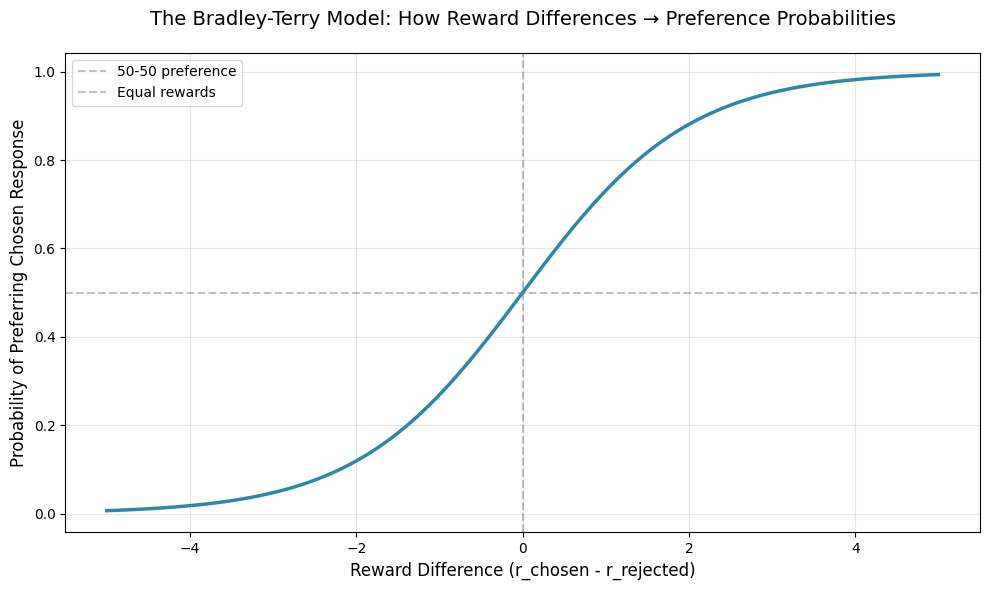

Understanding the curve:
When reward difference = 0:  P(prefer chosen) = 0.50
  → Both responses equally good, 50-50 coin flip

When reward difference = +2: P(prefer chosen) = 0.88
  → Chosen response scored 2 points higher, 88% confident

When reward difference = -2: P(prefer chosen) = 0.12
  → Uh oh! Chosen response scored LOWER. Only 12% confident.
  → This means our reward model is making a mistake!

The sigmoid squashes any difference into a nice probability.


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Visualize the Bradley-Terry model
reward_diff = np.linspace(-5, 5, 100)
prob_prefer_chosen = 1 / (1 + np.exp(-reward_diff))  # This is the sigmoid function

plt.figure(figsize=(10, 6))
plt.plot(reward_diff, prob_prefer_chosen, linewidth=2.5, color='#2E86AB')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50-50 preference')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Equal rewards')
plt.xlabel('Reward Difference (r_chosen - r_rejected)', fontsize=12)
plt.ylabel('Probability of Preferring Chosen Response', fontsize=12)
plt.title('The Bradley-Terry Model: How Reward Differences → Preference Probabilities', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Understanding the curve:")
print("=" * 60)
print(f"When reward difference = 0:  P(prefer chosen) = {1/(1+np.exp(0)):.2f}")
print("  → Both responses equally good, 50-50 coin flip")
print()
print(f"When reward difference = +2: P(prefer chosen) = {1/(1+np.exp(-2)):.2f}")  
print("  → Chosen response scored 2 points higher, 88% confident")
print()
print(f"When reward difference = -2: P(prefer chosen) = {1/(1+np.exp(2)):.2f}")
print("  → Uh oh! Chosen response scored LOWER. Only 12% confident.")
print("  → This means our reward model is making a mistake!")
print()
print("The sigmoid squashes any difference into a nice probability.")

## Reward Model Architecture

Alright, so how do we actually *build* this thing?

Turns out, a reward model is just a language model with one small addition: a **value head**.

Here's the architecture:

```
Input: [prompt] [response]  ← Concatenate these together
       ↓
┌─────────────────────────┐
│   Language Model        │  ← Start with a pre-trained model
│   (GPT, LLaMA, etc.)    │     (often the same one you used for SFT)
└───────────┬─────────────┘
            │
    Get the hidden state of the last token
    (this vector "summarizes" the whole sequence)
            │
            ↓
┌─────────────────────────┐
│     Value Head          │  ← A simple linear layer
│  (Linear → Scalar)      │     (this is the only new part!)
└───────────┬─────────────┘
            │
            ↓
       Reward Score
```

The idea: the language model reads the prompt + response and builds up a rich understanding of what's happening. Then the value head (just a tiny neural network—usually a single linear layer) converts that understanding into a single number: the reward.

You can either:
1. **Freeze the base model** (only train the value head)—faster, but less expressive
2. **Train everything**—slower, but the base model can learn to extract features specifically useful for predicting preferences

Most people train everything. You've already got the base model anyway, so why not use its full capacity?

Let's implement this.

In [2]:
from transformers import AutoModel, AutoTokenizer

class RewardModel(nn.Module):
    """
    A reward model for predicting human preferences.
    
    Takes a prompt + response, outputs a scalar reward score.
    """
    
    def __init__(self, base_model, hidden_size, freeze_base=False):
        super().__init__()
        self.base_model = base_model
        
        # Optionally freeze the base model (only train the value head)
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Value head: converts hidden state → scalar reward
        # (Just a linear layer with dropout for regularization)
        self.value_head = nn.Sequential(
            nn.Dropout(0.1),  # Prevent overfitting
            nn.Linear(hidden_size, 1)  # hidden_size → 1 number
        )
    
    def forward(self, input_ids, attention_mask):
        """
        Compute reward for an input sequence.
        
        Args:
            input_ids: Token IDs for [prompt] [response]
            attention_mask: 1 for real tokens, 0 for padding
            
        Returns:
            reward: Scalar score for this prompt-response pair
        """
        # Step 1: Run the base model to get hidden states
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        
        # Step 2: Get the last hidden state
        # Shape: (batch_size, sequence_length, hidden_size)
        hidden_states = outputs.last_hidden_state
        
        # Step 3: Extract the hidden state at the LAST non-padding token
        # Why the last token? It's "seen" the entire prompt + response,
        # so it has all the context needed to judge quality.
        
        # Find the position of the last real token for each sequence
        seq_lengths = attention_mask.sum(dim=1) - 1  # -1 for 0-indexing
        
        # Index into the hidden states to grab that last position
        batch_size = hidden_states.shape[0]
        last_hidden = hidden_states[
            torch.arange(batch_size),
            seq_lengths.long()
        ]
        
        # Step 4: Pass through value head to get scalar reward
        reward = self.value_head(last_hidden).squeeze(-1)
        
        return reward


# Let's create a reward model!
print("Building a reward model from GPT-2...")
print()

model_name = "gpt2"
base_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token by default

reward_model = RewardModel(
    base_model,
    hidden_size=base_model.config.hidden_size,
    freeze_base=False  # Train everything!
)

print(f"✓ Reward model created!")
print()
print(f"Base model parameters: {sum(p.numel() for p in base_model.parameters()):,}")
print(f"Value head parameters: {sum(p.numel() for p in reward_model.value_head.parameters()):,}")
print()
print("That value head is tiny! Just 769 parameters.")
print("(It's literally just: 768-dimensional vector → 1 number)")
print("But it's enough to learn human preferences when combined with the base model.")

Building a reward model from GPT-2...



✓ Reward model created!

Base model parameters: 124,439,808
Value head parameters: 769

That value head is tiny! Just 769 parameters.
(It's literally just: 768-dimensional vector → 1 number)
But it's enough to learn human preferences when combined with the base model.


## Testing the Reward Model

Let's take our brand new (untrained) reward model for a spin.

We'll give it two responses to the question "What is 2+2?":
1. A correct answer
2. An "I don't know" response

Before training, the rewards should be basically random. The model hasn't learned anything about preferences yet!

In [3]:
# Test forward pass with two responses
test_texts = [
    "What is 2+2? The answer is 4.",
    "What is 2+2? I don't know."
]

# Tokenize both responses
inputs = tokenizer(
    test_texts,
    padding=True,  # Pad to same length
    return_tensors="pt"  # Return PyTorch tensors
)

# Run through the reward model
with torch.no_grad():  # Don't compute gradients (we're just testing)
    rewards = reward_model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

print("Reward scores (before training):")
print("=" * 60)
for text, reward in zip(test_texts, rewards):
    print(f"  '{text}' → {reward.item():.4f}")

print()
print("Notice: the rewards are essentially random!")
print("The model has no idea that the first response is better.")
print()
print("After training on preference data, we'd expect:")
print("  - First response (correct answer): HIGH reward")
print("  - Second response (unhelpful): LOW reward")
print()
print("Let's learn how to train this thing...")

Reward scores (before training):
  'What is 2+2? The answer is 4.' → 8.2746
  'What is 2+2? I don't know.' → 10.6641

Notice: the rewards are essentially random!
The model has no idea that the first response is better.

After training on preference data, we'd expect:
  - First response (correct answer): HIGH reward
  - Second response (unhelpful): LOW reward

Let's learn how to train this thing...


## The Training Objective

Alright, we've got our model architecture. Now we need to train it.

Remember, we have preference data: lots of examples where humans said "Response A is better than Response B" for some prompt.

Our goal: teach the model to assign higher rewards to preferred responses.

We do this with the **ranking loss** (also called the "preference loss"):

$$\mathcal{L} = -\mathbb{E}_{(x, y_w, y_l)} \left[ \log \sigma(r_\theta(x, y_w) - r_\theta(x, y_l)) \right]$$

Okay, this looks scary. Let me break it down:

- $\mathcal{L}$ is the **loss** we're trying to minimize (the "badness" of our model's predictions)
- $\mathbb{E}_{(...)}$ means "expected value over..." (in practice, this means "average over all examples in your dataset")
- $(x, y_w, y_l)$ is one training example: a prompt $x$, winning response $y_w$, and losing response $y_l$
- $\log$ is the natural logarithm
- $\sigma(...)$ is sigmoid (remember from Bradley-Terry!)
- $r_\theta(x, y_w) - r_\theta(x, y_l)$ is the difference in rewards

So the whole thing reads: "The loss is the negative log probability that we assign the correct preference."

Why negative? Because we're *minimizing* the loss. Maximizing log probability = minimizing negative log probability. (Classic machine learning trick.)

**Intuitively:**
- If $r_\theta(x, y_w) > r_\theta(x, y_l)$ (we correctly ranked the winner higher), the loss is LOW. Good!
- If $r_\theta(x, y_w) < r_\theta(x, y_l)$ (we got it backwards—uh oh), the loss is HIGH. The gradient will push $r(y_w)$ up and $r(y_l)$ down.
- If $r_\theta(x, y_w) \approx r_\theta(x, y_l)$ (we're not sure), the loss is medium. We'll adjust the rewards to be more confident.

The beautiful thing about this loss: it doesn't care about the *absolute* values of rewards, only the *differences*. That means the model can scale its rewards however it wants, as long as the rankings are correct.

(This turns out to be important later when we use the reward model for RLHF—but one thing at a time!)

## Next Steps

We've covered the theory. Now let's make it real.

In the following notebooks, we'll cover:

1. **Preference Data** — Where does this data come from? What does it look like? How do we format it?
2. **Training** — Complete implementation of the training loop. We'll actually train a reward model!
3. **Evaluation** — How do you know if your reward model is good? (Accuracy alone isn't enough—we need to watch for reward hacking.)